# Crop Yield Prediction: XGBoost

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna visualization tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Making the plots look nice (standard setup)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

C:\Users\PavinP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Prep and Crop Choice
I'm loading the cleaned dataset (Part 3 parquet file) and setting the prediction target to **Rice**. I'll also clean up any rows that are missing the target yield.

In [2]:
# Loading the parquet file
df = pd.read_parquet('Parquet/XY_v3.parquet')

# Checking what crops we have
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("Crops available:", available_crops)
print("-" * 30)

# --- SETTING THE CROP HERE ---
CHOSEN_CROP = 'rice' 
# -----------------------------

TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y' # Keeping this lag feature for the model, it's usually important

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found. Check spelling.")

print(f"Target Variable: {TARGET_COL}")

# Dropping rows where the target is missing (can't train on those)
df_model = df.dropna(subset=[TARGET_COL])

print(f"Rows ready for training: {len(df_model)}")

Crops available: ['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
------------------------------
Target Variable: Y_rice
Rows ready for training: 4687


### 2. Splitting the Data
Since this is **time-series data**, I need to split the data by year. This makes sure the model isn't predicting an earlier year using data it wouldn't have known yet:

* **Train:** Data before 2014.
* **Validation:** Data from 2014-2018 (used for tuning).
* **Test:** Data from 2019+ (used for the final score).

In [3]:
# Cleaning up: Removing lag features that belong to other crops
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- Remove min/max TARGET_COL rows per country (robust version) ---
df_model = df_model.copy()

# Get row positions (not index labels)
idx_min = df_model.groupby('area')[TARGET_COL].idxmin().values
idx_max = df_model.groupby('area')[TARGET_COL].idxmax().values

# Combine them safely
rows_to_drop = np.concatenate([idx_min, idx_max])

# Drop by position, not by label
df_model = df_model.iloc[~df_model.index.isin(rows_to_drop)].reset_index(drop=True)


# Defining my X (features)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and not c.startswith('avg_yield_') and c not in ['area']]

print(f"Number of features: {len(feature_cols)}")
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# Training set
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# Validation set
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# Test set
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTrain size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

Number of features: 14


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Feature Name,year,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude



Train size: 3383
Val size:   541
Test size:  517


In [4]:
X_train.head()

,year,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude
0,1982,325.32,154.391016,59.402942,NaN,NaN,NaN,11.699167,-33.899342,-60.110408,NaN,5.778887,34.53,69.17
1,1983,373.54,186.787027,72.870980,NaN,NaN,NaN,10.650833,-42.640609,-60.922614,NaN,6.672946,34.53,69.17
2,1984,273.25,211.709895,-21.830163,NaN,NaN,NaN,11.383333,-46.025539,-55.929678,NaN,7.152971,34.53,69.17
3,1985,196.10,96.438281,33.467341,19.215833,-13.475498,-51.480910,11.888333,-39.599910,-69.677748,NaN,9.178255,34.53,69.17
4,1986,155.09,67.530475,38.964517,18.741667,-12.861915,-47.249218,12.511667,-31.144849,-60.631870,NaN,9.224020,34.53,69.17


### 3. Initial Model
I'm setting up a standard XGBoost model first, just to see what kind of baseline score I can get before tuning. I'm using `early_stopping` to keep it from overfitting to the training data.

[0]	validation_0-rmse:1831.54888	validation_1-rmse:2267.89908
[100]	validation_0-rmse:1330.00917	validation_1-rmse:1735.85951
[200]	validation_0-rmse:1118.76706	validation_1-rmse:1481.22315
[300]	validation_0-rmse:1010.53796	validation_1-rmse:1330.74061
[400]	validation_0-rmse:939.01584	validation_1-rmse:1242.61526
[500]	validation_0-rmse:888.05265	validation_1-rmse:1180.97628
[600]	validation_0-rmse:844.31113	validation_1-rmse:1134.43044
[700]	validation_0-rmse:807.77991	validation_1-rmse:1097.61638
[800]	validation_0-rmse:776.13337	validation_1-rmse:1067.86177
[900]	validation_0-rmse:746.86868	validation_1-rmse:1046.86669
[999]	validation_0-rmse:723.01273	validation_1-rmse:1026.65446


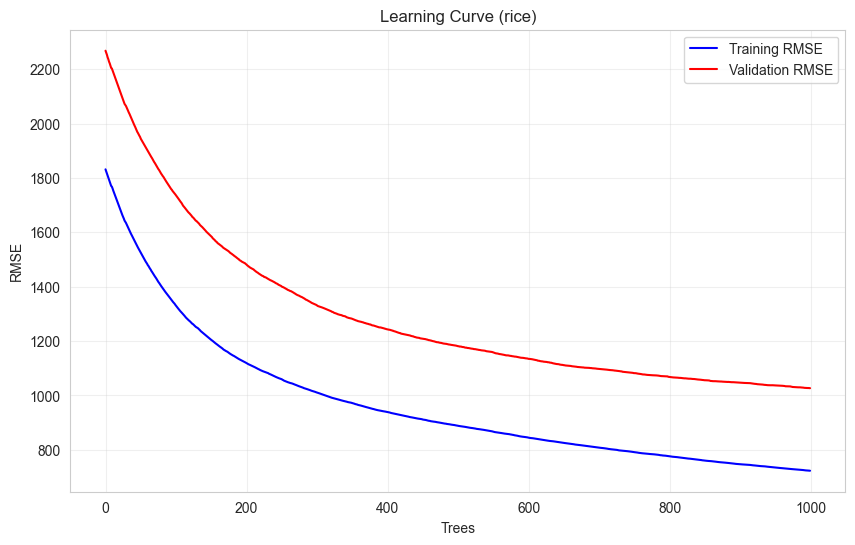

  Metric     Train  Validation       Test
0   RMSE  723.0127   1026.6545  1156.4032
1     R²    0.8455      0.7769     0.7142


In [5]:
# --- INITIAL MODEL TRAINING ---

model_init = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=4,
    subsample=0.7,
    colsample_bytree=0.4,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)


# Fitting the model
model_init.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=100  # print progress every 100 trees
)

# Getting results for the plot
results = model_init.evals_result()

# --- PLOTTING LEARNING CURVE ---
def plot_learning_curve(results, metric='rmse'):
    plt.figure(figsize=(10, 6))
    
    train_metric = results['validation_0'][metric]
    val_metric = results['validation_1'][metric]
    
    plt.plot(train_metric, label='Training RMSE', color='blue')
    plt.plot(val_metric, label='Validation RMSE', color='red')
    
    plt.title(f'Learning Curve ({CHOSEN_CROP})')
    plt.xlabel('Trees')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(results)

# Train predictions
y_pred_init_train = model_init.predict(X_train)
rmse_init_train = np.sqrt(mean_squared_error(y_train, y_pred_init_train))
r2_init_train = r2_score(y_train, y_pred_init_train)

# Validation predictions
y_pred_init_val = model_init.predict(X_val)
rmse_init_val = np.sqrt(mean_squared_error(y_val, y_pred_init_val))
r2_init_val = r2_score(y_val, y_pred_init_val)

# Test predictions
y_pred_init_test = model_init.predict(X_test)
rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

# --- Create table ---
metrics_table_init = pd.DataFrame({
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_init_train, r2_init_train],
    'Validation': [rmse_init_val, r2_init_val],
    'Test': [rmse_init_test, r2_init_test]
})

# Round for readability
metrics_table_init = metrics_table_init.round(4)

print(metrics_table_init)


### 4. Tuning with Optuna
The initial model seems okay, but I think I can improve the score by finding better hyperparameter settings. I'll run **Optuna** for 50 trials to try different combinations of learning rates, depths, and regularization.

In [6]:
# Defining the objective function for Optuna (relaxed search space)
def objective(trial):
    params = {
        "n_estimators": 1000,

        # learning rate slightly wider around best
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.012),

        # max_depth relaxed a bit
        "max_depth": trial.suggest_int("max_depth", 2, 4),

        # min_child_weight relaxed
        "min_child_weight": trial.suggest_int("min_child_weight", 4, 7),

        # subsample and colsample_bytree slightly wider
        "subsample": trial.suggest_float("subsample", 0.68, 0.78),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.41, 0.45),

        # regularization still small, but slightly wider range
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e-4, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1e-3, log=True),

        "random_state": 42,
        "n_jobs": -1,
        "early_stopping_rounds": 50
    }


    model = xgb.XGBRegressor(**params)
    
    # Training on train set, evaluating on validation set
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# Running the study
study_name = f'{CHOSEN_CROP}_optimization'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=100)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-12-10 12:42:54,068] A new study created in memory with name: rice_optimization
[I 2025-12-10 12:42:54,442] Trial 0 finished with value: 1267.040051271993 and parameters: {'learning_rate': 0.007623155021685283, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.7729982162428015, 'colsample_bytree': 0.42980026279748146, 'reg_alpha': 4.347394225747687e-06, 'reg_lambda': 1.5825993902928185e-06}. Best is trial 0 with value: 1267.040051271993.
[I 2025-12-10 12:42:54,887] Trial 1 finished with value: 1262.9367720491716 and parameters: {'learning_rate': 0.007809598742233217, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.7538534653055836, 'colsample_bytree': 0.4231602999546927, 'reg_alpha': 2.504159490870487e-06, 'reg_lambda': 2.5189001642200205e-06}. Best is trial 1 with value: 1262.9367720491716.
[I 2025-12-10 12:42:55,445] Trial 2 finished with value: 1021.2436214616625 and parameters: {'learning_rate': 0.009628173450159153, 'max_depth': 3, 'min_child_weight': 6, 'subsampl


Best Parameters found:
{'learning_rate': 0.011629104596868793, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.7782352413226794, 'colsample_bytree': 0.4397849704582514, 'reg_alpha': 2.44157105441616e-07, 'reg_lambda': 1.5380157732510628e-06}


### 5. Visualization
These plots show how the tuning went and which parameters were most important. It looks like Optuna found a few good combinations early on.

In [7]:
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_XGBoost"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 6. Final Model
I'm training the final version now. Since tuning is finished, I can **combine the Training and Validation sets** to give the model as much historical data as possible. Then I'll test it on the unseen Test set.

[0]	validation_0-rmse:1891.02212	validation_1-rmse:2245.74360
[100]	validation_0-rmse:1197.64157	validation_1-rmse:1526.31565
[200]	validation_0-rmse:946.75745	validation_1-rmse:1260.85120
[300]	validation_0-rmse:828.46012	validation_1-rmse:1134.36990
[400]	validation_0-rmse:756.01213	validation_1-rmse:1062.30950
[500]	validation_0-rmse:699.41654	validation_1-rmse:1011.35314
[600]	validation_0-rmse:653.97396	validation_1-rmse:968.98596
[700]	validation_0-rmse:618.52427	validation_1-rmse:939.86411
[800]	validation_0-rmse:587.02206	validation_1-rmse:913.85945
[900]	validation_0-rmse:562.70958	validation_1-rmse:896.01190
[999]	validation_0-rmse:540.47176	validation_1-rmse:879.35536


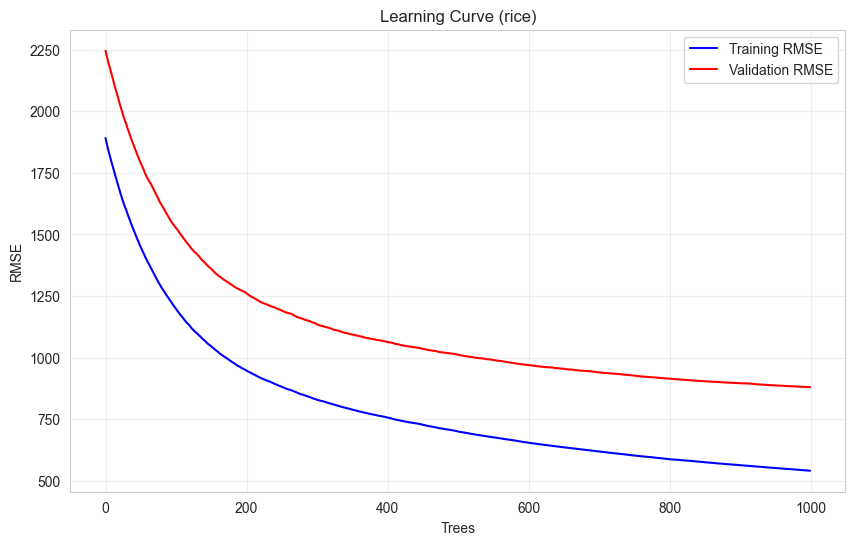

  Metric     Train  Validation      Test
0   RMSE  531.9524    590.9668  879.3535
1     R²    0.9164      0.9261    0.8348


In [8]:
# Merging train and val for the final model training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Setting up params (reusing best params found by Optuna)
best_params = study.best_params
best_params['n_estimators'] = 1000
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['early_stopping_rounds'] = 50

final_model = xgb.XGBRegressor(**best_params)

# Training on the full history
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_test, y_test)],
    verbose=100
)

results = final_model.evals_result()

# --- PLOTTING LEARNING CURVE ---
# Checking the curve one last time for the full training data
def plot_learning_curve(results, metric='rmse'):
    plt.figure(figsize=(10, 6))
    
    train_metric = results['validation_0'][metric]
    val_metric = results['validation_1'][metric]
    
    plt.plot(train_metric, label='Training RMSE', color='blue')
    plt.plot(val_metric, label='Validation RMSE', color='red')
    
    plt.title(f'Learning Curve ({CHOSEN_CROP})')
    plt.xlabel('Trees')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(results)

# Train predictions
y_pred_final_train = final_model.predict(X_train)
rmse_final_train = np.sqrt(mean_squared_error(y_train, y_pred_final_train))
r2_final_train = r2_score(y_train, y_pred_final_train)

# Validation predictions
y_pred_final_val = final_model.predict(X_val)
rmse_final_val = np.sqrt(mean_squared_error(y_val, y_pred_final_val))
r2_final_val = r2_score(y_val, y_pred_final_val)

# Test predictions
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

# --- Create table ---
metrics_table_final = pd.DataFrame({
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_final_train, r2_final_train],
    'Validation': [rmse_final_val, r2_final_val],
    'Test': [rmse_final_test, r2_final_test]
})

# Round for readability
metrics_table_final = metrics_table_final.round(4)

print(metrics_table_final)

### 7. Results Comparison
Let's see if the tuning actually helped. I'm comparing the RMSE of the Initial Model (default settings) vs. the Tuned Model (best settings found by Optuna).

--- Final Test Set Results ---
Initial Model: RMSE=1156.40, R2=0.7142
Tuned Model:   RMSE=879.35, R2=0.8348
Improvement:   23.96%


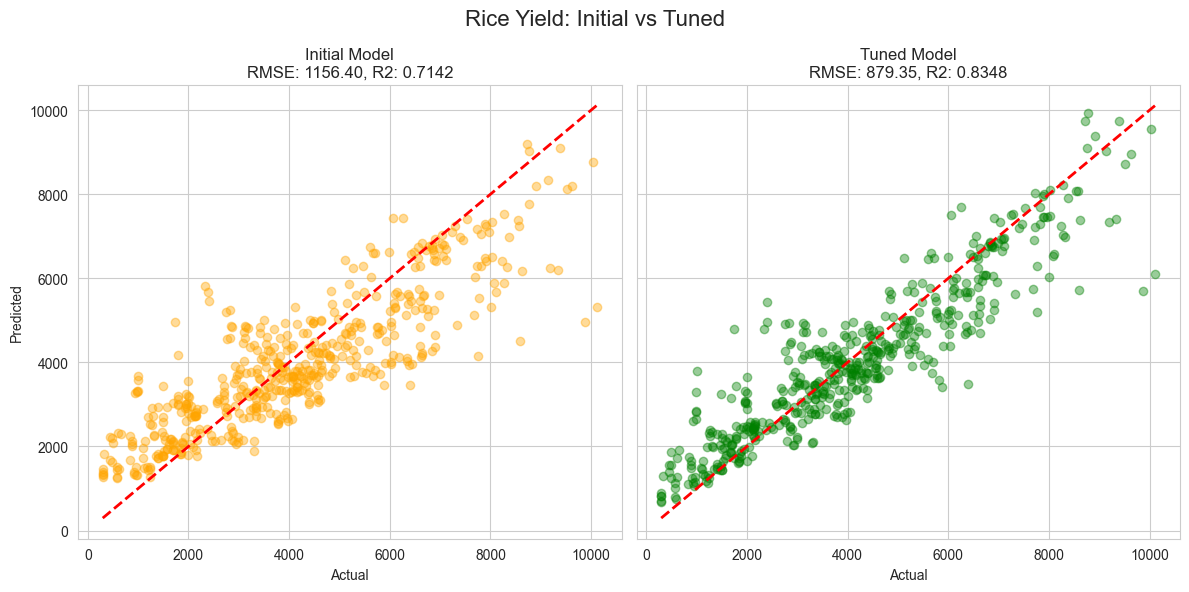

In [9]:
# Calculate improvement of Tuned Model over the Initial Model
imp_final = (rmse_init_test - rmse_final_test) / rmse_init_test * 100

print("--- Final Test Set Results ---")
print(f"Initial Model: RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:   RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f}")
print(f"Improvement:   {imp_final:.2f}%")

# --- PLOTTING ---
# Plotting the two models side-by-side (Initial and Tuned)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Setting axis limits so they match on both plots
all_preds = np.concatenate([y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# Initial Model Plot
axes[0].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(
    f'Initial Model\nRMSE: {rmse_init_test:.2f}, R2: {r2_init_test:.4f}'
)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Tuned Model Plot
axes[1].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(
    f'Tuned Model\nRMSE: {rmse_final_test:.2f}, R2: {r2_final_test:.4f}'
)
axes[1].set_xlabel('Actual')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Initial vs Tuned', fontsize=16)
plt.tight_layout()
plt.show()

### 8. Trend Analysis
I'll visualize how the model performed over the years. This helps check if it captures the general ups and downs.

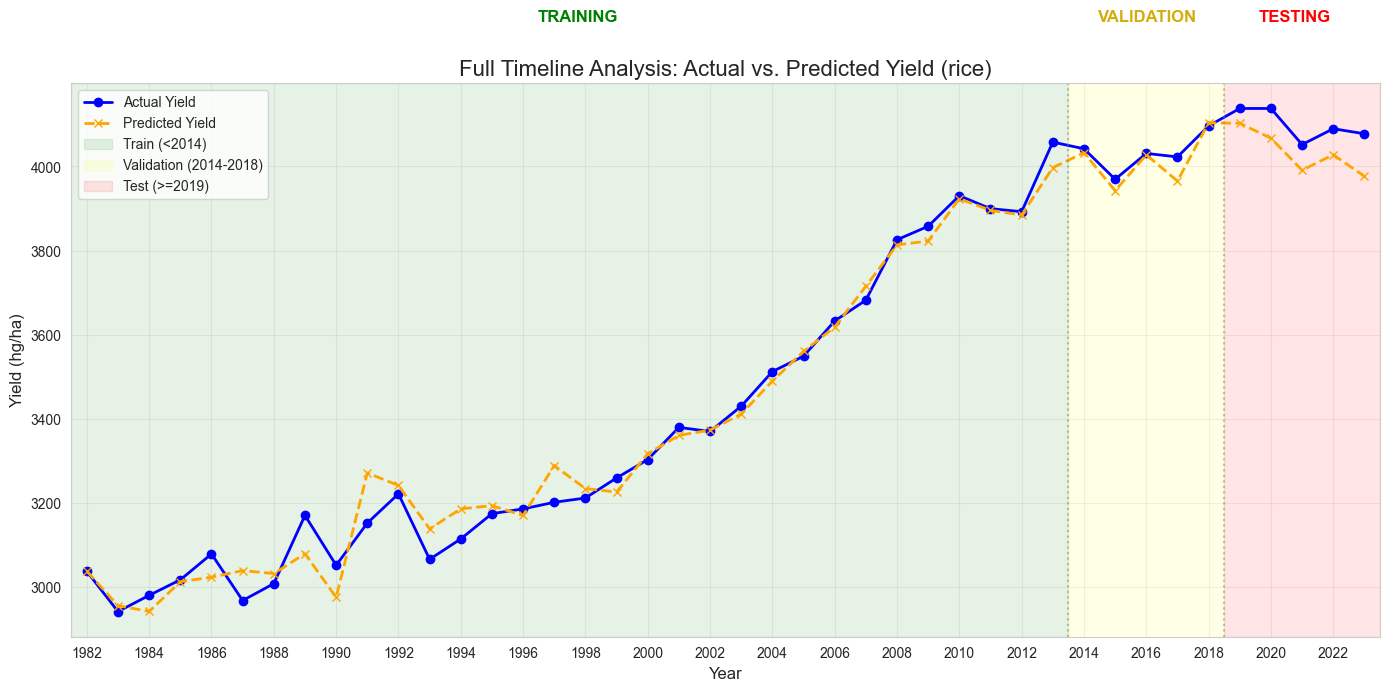

In [10]:

# 1. Predictions
all_predictions = final_model.predict(df_model[feature_cols])

# 2. Build DataFrame
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# 3. Aggregate yearly
yearly_trend = df_full_trend.groupby('Year').mean()

# 4. Plot
plt.figure(figsize=(14, 7))

# Plot lines
plt.plot(yearly_trend.index, yearly_trend['Actual'],
         marker='o', label='Actual Yield', linewidth=2, color='blue')

plt.plot(yearly_trend.index, yearly_trend['Predicted'],
         marker='x', linestyle='--', label='Predicted Yield', linewidth=2, color='orange')

# --- Boundaries ---
MIN_YEAR = yearly_trend.index.min()
MAX_YEAR = yearly_trend.index.max()

train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Shaded Regions ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1,
            label=f'Train (<{TRAIN_END_YEAR})')

plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1,
            label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')

plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1,
            label=f'Test (>={VAL_END_YEAR})')

# --- Split Lines ---
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# --- Labels ---
y_max = yearly_trend['Actual'].max()
text_y = y_max * 1.05

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING',
         ha='center', fontsize=12, fontweight='bold', color='green')

plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION',
         ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')

plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING',
         ha='center', fontsize=12, fontweight='bold', color='red')

# --- Final Styling ---
plt.title(f'Full Timeline Analysis: Actual vs. Predicted Yield ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

plt.tight_layout()
plt.show()


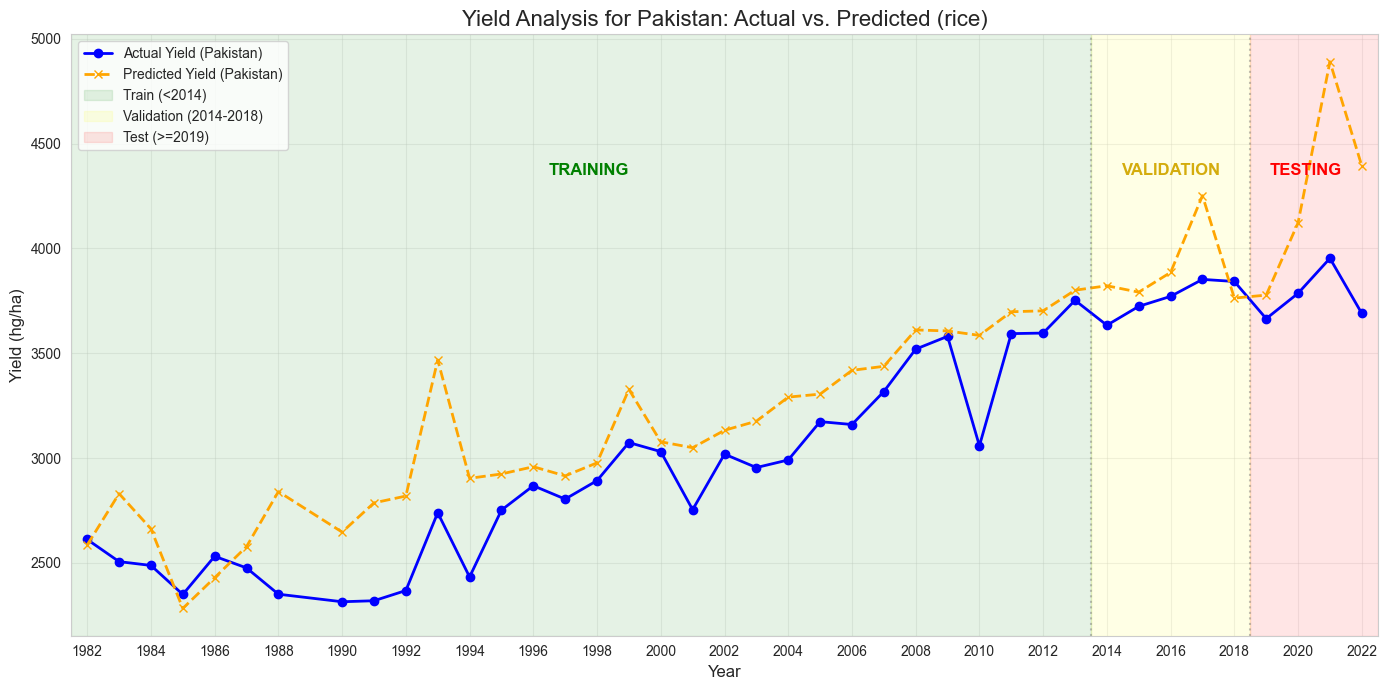

In [11]:
# --- Add country column ---
df_full_trend['Area'] = df_model['area']

# --- Country-specific trend ---
TARGET_COUNTRY = "Pakistan"
df_country = df_full_trend[df_full_trend['Area'] == TARGET_COUNTRY]
country_trend = df_country.groupby('Year')[['Actual', 'Predicted']].mean()

# --- Plot ---
plt.figure(figsize=(14, 7))

# Country lines
plt.plot(country_trend.index, country_trend['Actual'],
         marker='o', label=f'Actual Yield ({TARGET_COUNTRY})', linewidth=2, color='blue')
plt.plot(country_trend.index, country_trend['Predicted'],
         marker='x', linestyle='--', label=f'Predicted Yield ({TARGET_COUNTRY})', linewidth=2, color='orange')

# --- Boundaries ---
MIN_YEAR = country_trend.index.min()
MAX_YEAR = country_trend.index.max()
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Shaded regions ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, label=f'Train (<{TRAIN_END_YEAR})')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR-1})')
plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, label=f'Test (>={VAL_END_YEAR})')

# --- Split lines ---
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# --- Labels ---
y_max = country_trend['Actual'].max()
text_y = y_max * 1.1

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', ha='center', fontsize=12, fontweight='bold', color='green')
plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', ha='center', fontsize=12, fontweight='bold', color='red')

# --- Final styling ---
plt.title(f'Yield Analysis for {TARGET_COUNTRY}: Actual vs. Predicted ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)
plt.tight_layout()
plt.show()


### 9. Geographic Error Map
I want to see where the model makes the biggest mistakes. I'll map the error (RMSPE) by country.

In [12]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- 1. Prepare the test DataFrame ---
mask_test = df_model['year'] >= VAL_END_YEAR
test_context = df_model[mask_test][['area', 'year']]

comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
})

# Join back country info
comparison_df = comparison_df.join(test_context)

# --- 2. Filter only the latest year per country ---
latest_year = comparison_df.groupby('area')['year'].transform('max')
comparison_df_latest = comparison_df[comparison_df['year'] == latest_year]

print(comparison_df_latest.head())

     Actual_Value  Predicted_Value         area  year
39         4625.0      3854.483398  Afghanistan  2022
89         1790.3      3436.256348      Algeria  2023
129        1172.1      1297.082520       Angola  2023
169        6723.7      6599.096680    Argentina  2023
209        9516.2      8729.689453    Australia  2023


In [13]:
rmse_by_country = (
    comparison_df_latest
    .groupby('area')
    .apply(lambda x: np.sqrt(np.mean((x['Actual_Value'] - x['Predicted_Value'])**2)))
    .reset_index(name='RMSE')
)

# --- 3. Sort from highest to lowest RMSE ---
rmse_by_country_sorted = rmse_by_country.sort_values(by='RMSE', ascending=False)

# --- 4. Display result ---
print(rmse_by_country_sorted)

              area         RMSE
98      Tajikistan  4174.205859
88    Saudi Arabia  3046.689551
54         Jamaica  2783.520020
110     Uzbekistan  2545.302441
57           Kenya  2471.409082
..             ...          ...
13    Burkina Faso    20.341602
26            Cuba    12.245703
100    Timor-Leste     9.766211
44   Guinea-Bissau     3.099194
60      Madagascar     1.986182

[115 rows x 2 columns]


C:\Users\PavinP\AppData\Local\Temp\ipykernel_25952\901504587.py:4: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [14]:
# 1. Define the Top 10 Producers in order (Highest Production to Lowest)
top_10_production_order = [
    'India', 
    'China, mainland', 
    'Bangladesh', 
    'Indonesia', 
    'Vietnam', 
    'Thailand', 
    'Myanmar', 
    'Philippines', 
    'Pakistan', 
    'Cambodia'
]

# 2. Reorder your RMSE dataframe to match this specific list
# set_index makes 'area' the lookup key, reindex sorts it by our list, and reset_index restores the columns.
rmse_sorted_by_production = (
    rmse_by_country
    .set_index('area')
    .reindex(top_10_production_order)
    .reset_index()
)

# 3. Display the result
print(rmse_sorted_by_production)

              area        RMSE
0            India  439.874902
1  China, mainland  154.057520
2       Bangladesh  665.832812
3        Indonesia  281.331348
4          Vietnam  795.190430
5         Thailand  814.838721
6          Myanmar  198.661572
7      Philippines  294.781250
8         Pakistan  703.403125
9         Cambodia  202.379687


In [15]:
import plotly.express as px

# Fix country names
comparison_df_latest['area'] = comparison_df_latest['area'].replace({
    'United_States_of_America': 'United States',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'China, mainland': 'China',
    'Republic_of_Korea': 'South Korea'
})

# Calculating squared error
comparison_df_latest['Squared_Error'] = (comparison_df_latest['Actual_Value'] - comparison_df_latest['Predicted_Value']) ** 2

# Calculating percentage error squared for RMSPE
comparison_df_latest['Error_Pct'] = ((comparison_df_latest['Actual_Value'] - comparison_df_latest['Predicted_Value']) / (comparison_df_latest['Actual_Value'] + 1e-6)) ** 2

# Aggregating by country
map_data = comparison_df_latest.groupby('area').agg(
    RMSPE=('Error_Pct', lambda x: np.sqrt(x.mean()) * 100),
    RMSE=('Squared_Error', lambda x: np.sqrt(x.mean())),
    Actual_Mean=('Actual_Value', 'mean'),
    Predicted_Mean=('Predicted_Value', 'mean')
).reset_index()

map_data.rename(columns={'area':'Country'}, inplace=True)

# Plotting with hover data including RMSE
fig = px.choropleth(
    map_data,
    locations='Country',
    locationmode='country names',
    color='RMSPE',
    color_continuous_scale=['green', 'red'],
    range_color=[0, 50],
    title='Prediction Error by Country (RMSPE)',
    hover_data={
        'RMSPE': ':.2f',
        'RMSE': ':.2f',
        'Actual_Mean': ':.2f',
        'Predicted_Mean': ':.2f'
    }
)

fig.show()


C:\Users\PavinP\AppData\Local\Temp\ipykernel_25952\4034963136.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PavinP\AppData\Local\Temp\ipykernel_25952\4034963136.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PavinP\AppData\Local\Temp\ipykernel_25952\4034963136.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

### 10. Feature Importance
Finally, let's see which features the model thought were the most useful.


--- Top 20 Most Important Features (Text Report) ---
            Feature  Importance
0   fertilizer_lag1    0.165096
1          latitude    0.113481
2   pesticides_lag1    0.107181
3         solar_cos    0.097424
4         longitude    0.079101
5          temp_sin    0.074502
6       temp_annual    0.066155
7          temp_cos    0.059991
8      solar_annual    0.057948
9       rain_annual    0.055163
10             year    0.049192
11         rain_cos    0.033124
12        solar_sin    0.023543
13         rain_sin    0.018098


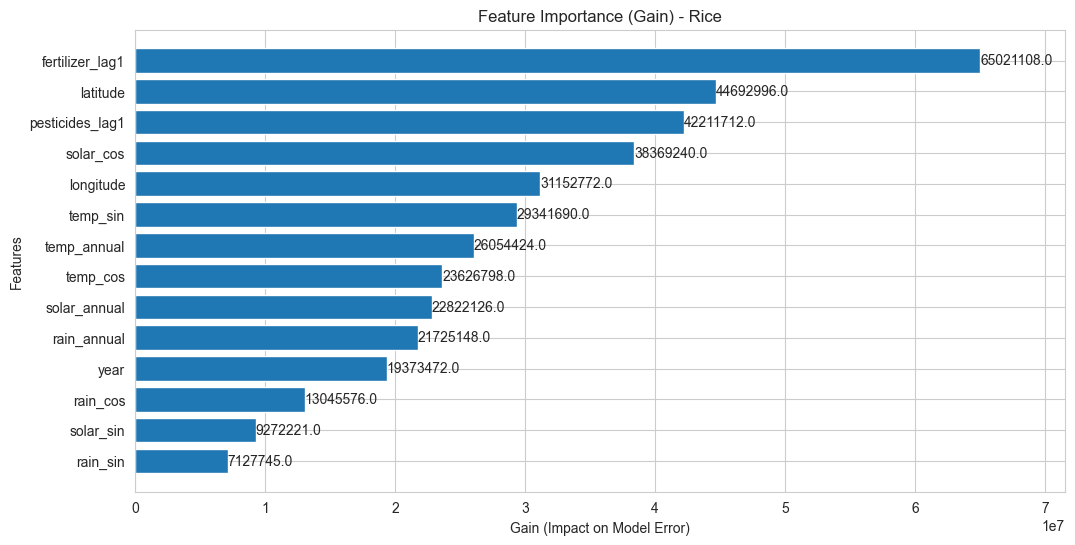

In [16]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances
importances = final_model.feature_importances_
feature_names = final_model.feature_names_in_

# 2. Create a DataFrame to display as text
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by importance
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH: Use XGBoost's built-in plotter
xgb.plot_importance(
    final_model, 
    max_num_features=20, 
    importance_type='gain', 
    height=0.8,
    xlabel='Gain (Impact on Model Error)',
    title=f'Feature Importance (Gain) - {CHOSEN_CROP.capitalize()}'
)
plt.show()